# <font color=red>SMU DS 7331 DATA MINING - MINILAB LOGISTIC REGRESSION AND SVMS</font>

**Team Members:**
- YuMei Bennett
- Liang Huang
- Ganesh Kodi
- Eric McCandless

## <font color=blue>CREATE MODELS (50 POINTS)</font>

**Create a logistic regression model and a support vector machine model for the classification task involved with your dataset. Assess how well each model performs (use 80/20 training/testing split for your data). Adjust parameters of the models to make them more accurate. If your dataset size requires the use of stochastic gradient descent, then linear kernel only is fine to use. That is, the SGDClassifier is fine to use for optimizing logistic regression and linear support vector machines. For many problems, SGD will be required in order to train the SVM model in a reasonable timeframe.**

We will use logistic regression to describe data and to explain the relationship between one dependent binary variable (<=50K, >50K income) and several independent variables. We will also use a support vector machine as a discriminative classifier which is based on a separating hyperplane to categorize new records.

We will compare the performance of each model.

Prep data for logistic regression model and support vector machine model:

In [1]:
# import all necessary modules
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import Imputer
import seaborn as sns

#Read in dataset.
col_names = ['age', 'employ_type', 'pop_num', 'edu_level', 'edu_years', 'marital', 'occ', 'relation', 'race', 'gender', 'cap_gain', 'cap_loss', 'hours_week', 'country_orig', 'income']
df = pd.read_csv('adult.csv', names=col_names, header=None)

#Replace "?" with "Other_cat"
df['employ_type'] = df['employ_type'].str.replace('?','Other_cat')
df['occ'] = df['occ'].str.replace('?','Other_cat')
df['country_orig'] = df['country_orig'].str.replace('?','Other_cat')

# Binary encoding of the target variable
df['income'] = df['income'].apply(lambda inc: 0 if inc ==" <=50K" else 1) 

#Transform employ_type into multiple columns with 0 and 1
# use pd.concat to join the new columns with original dataframe then drop the original 'employ_type' column (don't need it anymore)
df = pd.concat([df,pd.get_dummies(df['employ_type'], prefix='emp')],axis=1)
df.drop(['employ_type'],axis=1, inplace=True)

#Transform gender into multiple columns with 0 and 1
# use pd.concat to join the new columns with original dataframe then drop the original 'gender' column (don't need it anymore)
df = pd.concat([df,pd.get_dummies(df['gender'], prefix='gen')],axis=1)
df.drop(['gender'],axis=1, inplace=True)

#Transform race into multiple columns with 0 and 1
# use pd.concat to join the new columns with original dataframe then drop the original 'race' column (don't need it anymore)
df = pd.concat([df,pd.get_dummies(df['race'], prefix='rac')],axis=1)
df.drop(['race'],axis=1, inplace=True)

#Transform education_level into multiple columns with 0 and 1
# use pd.concat to join the new columns with original dataframe then drop the original 'edu_level' column (don't need it anymore)
df = pd.concat([df,pd.get_dummies(df['edu_level'], prefix='edu')],axis=1)
df.drop(['edu_level'],axis=1, inplace=True)

#Consolidate education levels because many of them have the similar impact to target income.
df['edu_ SomeCollege'] = df['edu_ Some-college'] + df['edu_ Assoc-acdm'] + df['edu_ Assoc-voc'] 
df['<HS'] = df['edu_ 12th'] + df['edu_ 11th'] + df['edu_ 10th'] + df['edu_ 9th'] + df['edu_ 7th-8th'] + df['edu_ 5th-6th']+ df['edu_ 1st-4th'] + df['edu_ Preschool'] 
df=df.drop(['edu_ Some-college','edu_ Assoc-acdm','edu_ Assoc-voc', 'edu_ 12th', 'edu_ 11th','edu_ 10th','edu_ 9th','edu_ 7th-8th','edu_ 7th-8th','edu_ 5th-6th','edu_ 1st-4th','edu_ Preschool'], 1)

# drop edu_years as it is highly correlated with edu_level.
df=df.drop(['edu_years'], 1)

#Transform relation into multiple columns with 0 and 1
# use pd.concat to join the new columns with original dataframe then drop the original 'relation' column (don't need it anymore)
df = pd.concat([df,pd.get_dummies(df['relation'], prefix='rel')],axis=1)
df.drop(['relation'],axis=1, inplace=True)

#Transform marital into multiple columns with 0 and 1
# use pd.concat to join the new columns with original dataframe then drop the original 'marital' column (don't need it anymore)
df = pd.concat([df,pd.get_dummies(df['marital'], prefix='mar')],axis=1)
df.drop(['marital'],axis=1, inplace=True)

#Consolidate marital status because too many similar categories.  Married-civ-spouse and Married-AF-spouse are similar as are non-married.
df['Married'] = df['mar_ Married-civ-spouse'] + df['mar_ Married-AF-spouse'] 
df['Sep_Div_Absent_Wid'] = df['mar_ Divorced'] + df['mar_ Separated'] + df['mar_ Widowed'] + df['mar_ Married-spouse-absent']
df['Never_Married'] = df['mar_ Never-married']
df=df.drop(['mar_ Married-civ-spouse','mar_ Married-AF-spouse','mar_ Divorced', 'mar_ Separated', 'mar_ Widowed','mar_ Married-spouse-absent','mar_ Never-married'], 1)

#Transform occ into multiple columns with 0 and 1
# use pd.concat to join the new columns with original dataframe then drop the original 'occ' column (don't need it anymore)
df = pd.concat([df,pd.get_dummies(df['occ'], prefix='occu')],axis=1)
df.drop(['occ'],axis=1, inplace=True)

#Consolidate occupation by combining 'Other-service', 'Other_cat', and 'Armed-Forces. 'Other' categories are combined because they are not defined and Armed-Forces has an extremely small number of occurences.
df['occu_ Other'] = df['occu_ Other-service'] + df['occu_ Other_cat'] + df['occu_ Armed-Forces'] 
df=df.drop(['occu_ Other-service','occu_ Other_cat','occu_ Armed-Forces'], 1)

# drop pop_num as population number is an assigned index number, it has no meaning or contribution to our target income.
df=df.drop(['pop_num'], 1)

# Combine all non-U.S. native countries as only ~10% people are not from US - code native country into binary 1=United-States
df['country_orig'] = df['country_orig'].apply(lambda inc: 1 if inc ==" United-States" else 0) 

# merge capital gain and capital losscap_gain and cap_loss as it can be mathmatically concatenated into a single feature cap_gain_loss = cap_gain - cap_loss.
df['cap_gain-loss'] = df['cap_gain'] - df['cap_loss'] 
df=df.drop(['cap_gain','cap_loss'], 1)
df.head(10)

#Run logistic and supprt vetor machine model
#Use 80/20 training/testing split

,age,hours_week,country_orig,income,emp_ Federal-gov,emp_ Local-gov,emp_ Never-worked,emp_ Other_cat,emp_ Private,emp_ Self-emp-inc,...,occu_ Handlers-cleaners,occu_ Machine-op-inspct,occu_ Priv-house-serv,occu_ Prof-specialty,occu_ Protective-serv,occu_ Sales,occu_ Tech-support,occu_ Transport-moving,occu_ Other,cap_gain-loss
0,39,40,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2174
1,50,13,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,38,40,1,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
3,53,40,1,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
4,28,40,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
5,37,40,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
6,49,16,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
7,52,45,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,31,50,1,1,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,14084
9,42,40,1,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,5178


Set-up 80/20 training/testing to split data:

In [2]:
from sklearn.model_selection import ShuffleSplit

# we want to predict the X and y data as follows:
if 'income' in df:
    y = df['income'].values # get the labels we want
    del df['income'] # get rid of the class label
    X = df.values # use everything else to predict!

    ## X and y are now numpy matrices, by calling 'values' on the pandas data frames we
    #    have converted them into simple matrices to use with scikit learn
    
    
# to use the cross validation object in scikit learn, we need to grab an instance
#    of the object and set it up. This object will be able to split our data into 
#    training and testing splits
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)
                         
print(cv_object)

ShuffleSplit(n_splits=3, random_state=None, test_size=0.2, train_size=None)


Run logistic regression:

In [3]:
# run logistic regression and vary some parameters
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt

# first we create a reusable logisitic regression object
#   here we can setup the object with different learning parameters and constants
lr_clf = LogisticRegression(penalty='l2', C=1.0, class_weight=None) # get object

# now we can use the cv_object that we setup before to iterate through the 
#    different training and testing sets. Each time we will reuse the logisitic regression 
#    object, but it gets trained on different data each time we use it.

iter_num=0
# the indices are the rows used for training and testing in each iteration
for train_indices, test_indices in cv_object.split(X,y): 
    # I will create new variables here so that it is more obvious what 
    # the code is doing (you can compact this syntax and avoid duplicating memory,
    # but it makes this code less readable)
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    # train the reusable logisitc regression model on the training data
    lr_clf.fit(X_train,y_train)  # train object
    y_hat = lr_clf.predict(X_test) # get test set precitions

    # now let's get the accuracy and confusion matrix for this iterations of training/testing
    acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    print("====Iteration",iter_num," ====")
    print("accuracy", acc )
    print("confusion matrix\n",conf)
    iter_num+=1
    
# Also note that every time you run the above code
#   it randomly creates a new training and testing set, 
#   so accuracy will be different each time

====Iteration 0  ====
accuracy 0.8504529402732995
confusion matrix
 [[4587  382]
 [ 592  952]]
====Iteration 1  ====
accuracy 0.8479963150621833
confusion matrix
 [[4603  333]
 [ 657  920]]
====Iteration 2  ====
accuracy 0.8423153692614771
confusion matrix
 [[4555  335]
 [ 692  931]]


The logistic regression shows approximately 84% - 85% accuracy for these runs. The upper left and lower right indicate how many records were classified correctly as <=50K and >50K income.

Weights are not normalized. We want to normalize the features based upon the mean and standard deviation of each column. This will give us true comparative weights.

In [4]:
from sklearn.preprocessing import StandardScaler
# we want to normalize the features based upon the mean and standard deviation of each column. 
# However, we do not want to accidentally use the testing data to find out the mean and std (this would be snooping)

from sklearn.pipeline import Pipeline
# you can apply the StandardScaler function inside of the cross-validation loop 
#  but this requires the use of PipeLines in scikit. 
#  A pipeline can apply feature pre-processing and data fitting in one compact notation
#  Here is an example!

std_scl = StandardScaler()
lr_clf = LogisticRegression(penalty='l2', C=0.05) 

# create the pipline
piped_object = Pipeline([('scale', std_scl),  # do this
                         ('logit_model', lr_clf)]) # and then do this

#------------------Commented, since didnt understand the implementation.. Need to discuss-------------
weights = []
# run the pipline cross validated
for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(X,y)):
    piped_object.fit(X[train_indices],y[train_indices])  # train object
    # it is a little odd getting trained objects from a  pipeline:
    weights.append(piped_object.named_steps['logit_model'].coef_[0])
    

weights = np.array(weights)

#-----------------------------------------------------------------------------------------------------

lr_clf.fit(X_train,y_train)  # train object
y_hat = lr_clf.predict(X_test) # get test set precitions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('accuracy:', acc )
print(conf )

C:\Users\lhuang\AppData\Local\Continuum\anaconda37\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\lhuang\AppData\Local\Continuum\anaconda37\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\lhuang\AppData\Local\Continuum\anaconda37\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\lhuang\AppData\Local\Continuum\anaconda37\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\lhuang\AppData\Local\Contin

accuracy: 0.8420082911100876
[[4576  314]
 [ 715  908]]


In [5]:
#----------------------------Why do we need explained above-----------------------------------------
# okay, so run through the cross validation loop and set the training and testing variable for one single iteration
for train_indices, test_indices in cv_object.split(X,y): 
    # I will create new variables here so that it is more obvious what 
    # the code is doing (you can compact this syntax and avoid duplicating memory,
    # but it makes this code less readable)
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
#-------------------------------------------------------------------------------------------------
    
X_train_scaled = std_scl.transform(X_train) # apply to training
X_test_scaled = std_scl.transform(X_test)

C:\Users\lhuang\AppData\Local\Continuum\anaconda37\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\lhuang\AppData\Local\Continuum\anaconda37\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Run support vector machine model:

In [6]:
# lets investigate SVMs on the data and play with the parameters and kernels
from sklearn.svm import SVC

# train the model just as before
svm_clf = SVC(C=0.5, kernel='rbf', degree=3, gamma='auto') # get object
svm_clf.fit(X_train_scaled, y_train)  # train object

y_hat = svm_clf.predict(X_test_scaled) # get test set precitions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('accuracy:', acc )
print(conf)

accuracy: 0.8504529402732995
[[4626  315]
 [ 659  913]]


The support vector machine shows approximately 85% accuracy. The upper left and lower right indicate how many records were classified correctly as <=50K and >50K income.

Look at support vectors:

In [7]:
# look at the support vectors
print(svm_clf.support_vectors_.shape)
print(svm_clf.support_.shape)
print(svm_clf.n_support_ )

(9570, 49)
(9570,)
[4973 4597]


Examine kernals:

In [8]:
# train the model just as before
svm_clf_lin = SVC(kernel='linear')# Linear Kernel
svm_clf_lin.fit(X_train_scaled, y_train)  # train object

y_hat_lin = svm_clf_lin.predict(X_test_scaled) # get test set precitions

acc_lin = mt.accuracy_score(y_test,y_hat_lin)
conf_lin = mt.confusion_matrix(y_test,y_hat_lin)
print('accuracy:', acc_lin )
print(conf_lin)

accuracy: 0.849531705819131
[[4632  309]
 [ 671  901]]


In [9]:
# train the model just as before
svm_clf_pol = SVC(kernel='poly')# Polynomial Kernel
svm_clf_pol.fit(X_train_scaled, y_train)  # train object

y_hat_pol = svm_clf_pol.predict(X_test_scaled) # get test set precitions

acc_pol = mt.accuracy_score(y_test,y_hat_pol)
conf_pol = mt.confusion_matrix(y_test,y_hat_pol)
print('accuracy:', acc_pol )
print(conf_pol)

accuracy: 0.8424689083371718
[[4603  338]
 [ 688  884]]


## <font color=blue>MODEL ADVANTAGES (10 POINTS)</font>

**Discuss the advantages of each model for each classification task. Does one type of model offer superior performance over another in terms of prediction accuracy? In terms of training time or efficiency? Explain in detail.**

Logistic regression and SVM in linear mode offer similar prediction accuracy. The model taining time in our case runs equally fast, that's probably due to our dataset size is reasonable, not overally large and we are only using linear kernal for SVM. SVM with none linear lernel does take a longer time to run compare to LR on the same dataset. 

From a mathmatical perspective, logistic regression is strickly convex where SVMs are only convex, so that helps LR be faster from an optimization perspective, but that doesn't always translate to faster. Part of this is because, computationally, SVMs are simpler. LR requires computing the exp function, which is bit more expansive then just the max. function used in SVMs. 

Logistic regression focuses on maximizing the probability of the data. SVM tries to find the separating hyperplane that maximizes the distance of the closest points to the margin. If a point is not a support vector, it doesn't matter. When SVM is run with linear mode, both are about equally effective. LR as its name suggests, can only separate data that is linearly separable. While SVM has the advantage of various different kernel modes, which can be a lot of more useful for a dataset that isn't separable (or not very separable) with a straight line.   

## <font color=blue>INTERPRET FEATURE IMPORTANCE (30 POINTS)</font>

**Use the weights from logistic regression to interpret the importance of different features for the classification task. Explain your interpretation in detail. Why do you think some variables are more important?**

<HS has weight of -1.7339507930665774
Never_Married has weight of -1.3011571275624016
gen_ Female has weight of -1.069405481779572
rel_ Own-child has weight of -1.0377552202453588
edu_ HS-grad has weight of -0.9786461244315091
occu_ Other has weight of -0.8753143303779651
Sep_Div_Absent_Wid has weight of -0.8409219901743902
occu_ Farming-fishing has weight of -0.7486740631471983
emp_ Self-emp-not-inc has weight of -0.7279181274318403
occu_ Handlers-cleaners has weight of -0.6316406006043868
rel_ Unmarried has weight of -0.5828496856802633
edu_ SomeCollege has weight of -0.5719058898460427
rac_ Black has weight of -0.4794282222291893
gen_ Male has weight of -0.448140604469623
occu_ Machine-op-inspct has weight of -0.4298981507816959
rel_ Other-relative has weight of -0.41524521921194185
emp_ Local-gov has weight of -0.371040204774372
emp_ State-gov has weight of -0.3661620774622418
rac_ Asian-Pac-Islander has weight of -0.35658721744958083
rac_ White has weight of -0.2856945710940424
em

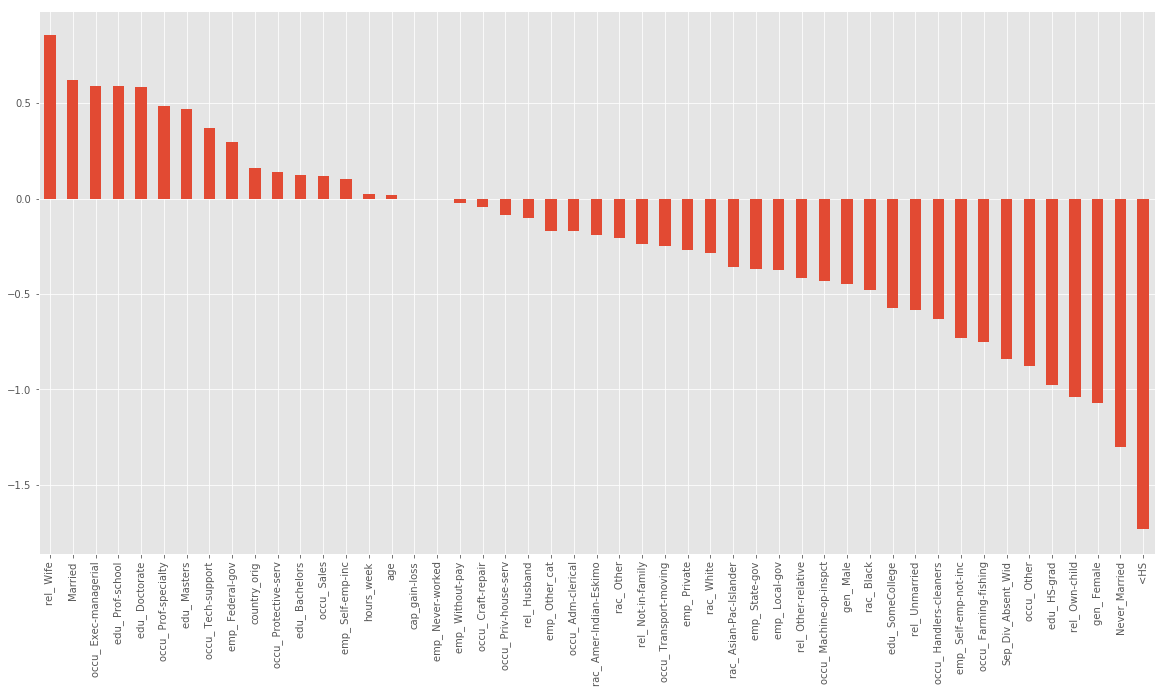

In [10]:
# sort these attributes and spit them out
zip_vars = zip(lr_clf.coef_.T,df.columns) # combine attributes
zip_vars = sorted(zip_vars)
for coef, name in zip_vars:
    print(name, 'has weight of', coef[0]) # now print them out
    
# now let's make a pandas Series with the names and values, and plot them
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
plt.figure(figsize = (20,10))
weights = pd.Series(lr_clf.coef_[0],index=df.columns)
weights = weights.sort_values(ascending=False)
weights.plot(kind='bar')
plt.show()

Based on above weightage and bar graph analysis we proceed by weighting features by level of importance and sorting them from highest to lowest in predicting whether or not income level fits into below 55K level or above. We have analysed five important features below
1. cap_gain-loss --> composite feature of capital gain and loss is taking high precendence or as the strongest predictor of income level with a weight value of 1.27 (e^1.27 = 3.56). Odds of person with highest cap_gain_los will fall into >55K income level increases by a factor of 3.26 compared to a person with lower cap_gain_loss.
2. Never_Married status of Marital feature -->  Never married status of Martial feature is an important predictor of income level (in negative) with a weight value of -0.450 (e^-0.450 = 0.637). Odds of a person with Never Married status will fall into <55K income level and making to >55 level decreases by a factor of (1-0.637 = 0.363) compared to a person with other Marital status level.
3. Married status of Marital feature --> Same as Never Married status, a odds of a Married status person making to >55 level increases by a factor of 1.83 (e^0.605) compared to a person with other Marital status level. Also, it might be correlated with the age and experience of married person which could mean chances of higher salary.
4. hours_week --> hours_week is one of the highest predictors of income level with a weight value of 0.363. Odds of a person with highest hours_week will fall into > 55K income level increases by a factor of 1.437 compared to a person with lesser hours_week. Reason might be due to extra allowances or a higher responsibility level to work more, which is inline with higher salary 
5. Education level  '<HS'  --> <HS level of Education feature is one of the important predictors of income level with a weight value (in negative) of -0.395 (e^-0.395 = 0.67). Odds of a person with education lesser than HS will fall into the <55K income level and making to the >55 level decreases by a factor of (1-0.7 = 0.33) than the person with other educational level

## <font color=blue>INTERPRET SUPPORT VECTORS (10 POINTS)</font>

**Look at the chosen support vectors for the classification task. Do these provide any insight into the data? Explain. If you used stochastic gradient descent (and therefore did not explicitly solve for support vectors), try subsampling your data to train the SVC model— then analyze the support vectors from the subsampled dataset.**

In [11]:
# Now let's do some different analysis with the SVM and look at the instances that were chosen as support vectors

# now lets look at the support for the vectors and see if we they are indicative of anything
# grabe the rows that were selected as support vectors (these are usually instances that are hard to classify)

# make a dataframe of the training data
df_tested_on = df.iloc[train_indices] # saved from above, the indices chosen for training
# now get the support vectors from the trained model
df_support = df_tested_on.iloc[svm_clf.support_,:]

df_support['ICM'] = y[svm_clf.support_] # add back in the 'Survived' Column to the pandas dataframe
df['ICM'] = y # also add it back in for the original data
df_support.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9570 entries, 21171 to 7222
Data columns (total 50 columns):
age                        9570 non-null int64
hours_week                 9570 non-null int64
country_orig               9570 non-null int64
emp_ Federal-gov           9570 non-null uint8
emp_ Local-gov             9570 non-null uint8
emp_ Never-worked          9570 non-null uint8
emp_ Other_cat             9570 non-null uint8
emp_ Private               9570 non-null uint8
emp_ Self-emp-inc          9570 non-null uint8
emp_ Self-emp-not-inc      9570 non-null uint8
emp_ State-gov             9570 non-null uint8
emp_ Without-pay           9570 non-null uint8
gen_ Female                9570 non-null uint8
gen_ Male                  9570 non-null uint8
rac_ Amer-Indian-Eskimo    9570 non-null uint8
rac_ Asian-Pac-Islander    9570 non-null uint8
rac_ Black                 9570 non-null uint8
rac_ Other                 9570 non-null uint8
rac_ White                 9570 non-null ui

C:\Users\lhuang\AppData\Local\Continuum\anaconda37\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


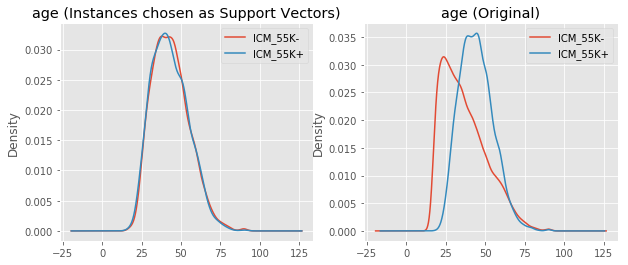

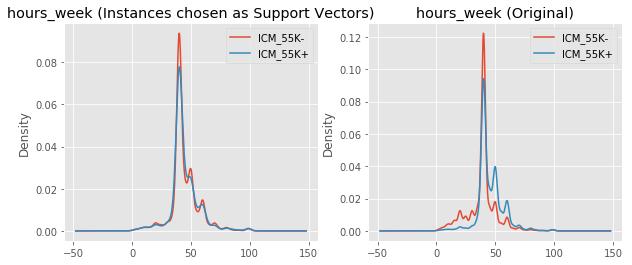

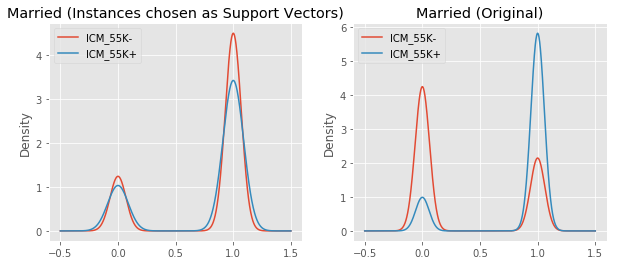

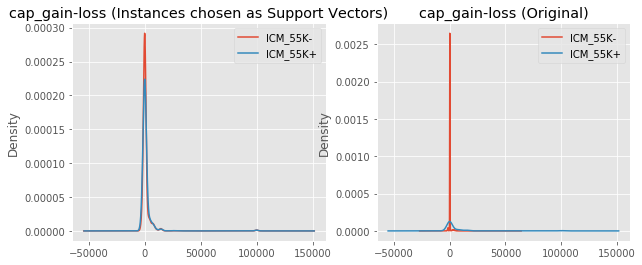

In [12]:
# now lets see the statistics of these attributes
#from pandas.tools.plotting import boxplot
from pandas.plotting import boxplot

# group the original data and the support vectors
df_grouped_support = df_support.groupby(['ICM'])
df_grouped = df.groupby(['ICM'])

# plot KDE of Different variables
vars_to_plot = ['age','hours_week','Married','cap_gain-loss']

for v in vars_to_plot:
    plt.figure(figsize=(10,4))
    # plot support vector stats
    plt.subplot(1,2,1)
    ax = df_grouped_support[v].plot.kde() 
    plt.legend(['ICM_55K-','ICM_55K+'])
    plt.title(v+' (Instances chosen as Support Vectors)')
    
    # plot original distributions
    plt.subplot(1,2,2)
    ax = df_grouped[v].plot.kde() 
    plt.legend(['ICM_55K-','ICM_55K+'])
    plt.title(v+' (Original)')

So the analysis here is basically telling us what the original statistics of the data looked like, and also what the statistics of the support vectors looked like. We can see that the separation in distributions is not as great as the separation for the original data. This is because the support vectors tend to be instances on the edge of the class boundaries and also instances that are classified incorrectly in the training data.